In [2]:
from fairness_sdk.data_preparation import RAFDB_subgroups_init, RAFDB_loader_api
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

## 1. Chargement des données de RAF-DB
### 1. 1 Définition des constantes (chemin de la BD, dimensions, etc.)

In [3]:
FEATURES_PATH = '/export/livia/home/datasets/RAF/basic/Image/aligned/'
ANNOTATIONS_PATH = '/export/livia/home/datasets/RAF/basic/Annotation/manual/Landmarks_5/'
LABELS_PATH = '/export/livia/home/datasets/RAF/basic/EmoLabel/list_patition_label.txt'
img_rows, img_cols, img_channels, num_classes = 224, 224, 3, 7

### 1. 2 Chargement des données

In [4]:
raf_db = RAFDB_loader_api(FEATURES_PATH, ANNOTATIONS_PATH, LABELS_PATH, True)

### 1. 3 Initialisation des sous-groupes

In [5]:
train_images_gender, train_labels_gender, train_images_race, train_labels_race = RAFDB_subgroups_init()

### 1. 4. 1 Séparation des sous-groupes (pour la visualisation)

In [6]:
train_images_gender['male'] = np.array(raf_db['images_gender']['male'])
train_labels_gender['male'] = np.array(raf_db['labels_gender']['male'])
train_images_gender['female'] = np.array(raf_db['images_gender']['female'])
train_labels_gender['female'] = np.array(raf_db['labels_gender']['female'])

train_images_race['caucasian'] = np.array(raf_db['images_race']['caucasian'])
train_labels_race['caucasian'] = np.array(raf_db['labels_race']['caucasian'])
train_images_race['asian'] = np.array(raf_db['images_race']['asian'])
train_labels_race['asian'] = np.array(raf_db['labels_race']['asian'])
train_images_race['african'] = np.array(raf_db['images_race']['african'])
train_labels_race['african'] = np.array(raf_db['labels_race']['african'])

## 2. Pré-traitement des données
### 2. 1 Balancement de données avec la méthode d'Over Sampling

In [7]:
# Take the subgroup with the highest number of instances
max_samples = max(
    len(train_images_gender['male']),
    len(train_images_gender['female']),
    len(train_images_race['asian']),
    len(train_images_race['caucasian']),
    len(train_images_race['african'])
)

In [8]:
# Over sampling gender subgroup
for gender in ['male', 'female']:
    if len(train_images_gender[gender]) > max_samples:
        indices = np.random.choice(len(train_images_gender[gender]), max_samples, replace=False)
        train_images_gender[gender] = train_images_gender[gender][indices]
        train_labels_gender[gender] = train_labels_gender[gender][indices]
    elif len(train_images_gender[gender]) < max_samples:
        num_samples = max_samples - len(train_images_gender[gender])
        indices = np.random.choice(len(train_images_gender[gender]), num_samples, replace=True)
        train_images_gender[gender] = np.concatenate((train_images_gender[gender], train_images_gender[gender][indices]))
        train_labels_gender[gender] = np.concatenate((train_labels_gender[gender], train_labels_gender[gender][indices]))

In [9]:
# Over sampling race subgroup
for race in train_images_race.keys():
    num_samples = len(train_images_race[race])
    if num_samples < max_samples:
        num_samples_to_add = max_samples - num_samples
        random_indices = np.random.choice(num_samples, num_samples_to_add)
        train_images_race[race] = np.concatenate((train_images_race[race], train_images_race[race][random_indices]), axis=0)
        train_labels_race[race] = np.concatenate((train_labels_race[race], train_labels_race[race][random_indices]), axis=0)

### 2. 2 Reconstruction de la base de données

In [10]:
# Combine the subgroups into a single dataset
train_images = np.concatenate((train_images_gender['male'], train_images_gender['female'], train_images_race['caucasian'], train_images_race['asian'], train_images_race['african']), axis=0)
train_labels = np.concatenate((train_labels_gender['male'], train_labels_gender['female'], train_labels_race['caucasian'], train_labels_race['asian'], train_labels_race['african']), axis=0)

## 3. Augmentation de la base de données

In [11]:
# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Create an instance of the ImageDataGenerator class with the desired data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20, # Rotate images randomly by 20 degrees
    width_shift_range=0.1, # Shift images horizontally by up to 10% of the width
    height_shift_range=0.1, # Shift images vertically by up to 10% of the height
    shear_range=0.2, # Apply shearing transformation with a maximum shear of 20%
    zoom_range=0.2, # Randomly zoom in and out by 20%
    horizontal_flip=True, # Flip images horizontally
    fill_mode='nearest' # Fill any empty pixels with the nearest value
)

# Fit the ImageDataGenerator to the training data
datagen.fit(train_images)

## 4. Apprentissage de VGG19 avec fine tuning, augmentation et balancement

In [13]:
# Instantiate the model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channels))

# Add a global average pooling layer and a dense layer on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the VGG19 layers
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the top 10 layers (fine tuning)
for layer in model.layers[-10:]:
    layer.trainable = True

# Compile the model
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
batch_size = 32
steps_per_epoch = train_images.shape[0] // batch_size
validation_steps = val_images.shape[0] // batch_size

train_generator = datagen.flow(train_images, train_labels, batch_size=batch_size, shuffle=True)
val_generator = datagen.flow(val_images, val_labels, batch_size=batch_size, shuffle=False)

In [14]:
# Define checkpoint and early stopping callbacks
checkpoint_dir = './checkpoints'
checkpoint_file = checkpoint_dir + '/best_aumented_balanced_VGG19.h5'
checkpoint = ModelCheckpoint(filepath=checkpoint_file, monitor='val_accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min')

In [15]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=300, validation_data=val_generator, validation_steps=validation_steps, callbacks=[checkpoint, early_stop], verbose=1)

Epoch 1/300
1173/1173 [==============================] - 789s 664ms/step - loss: 1.2573 - accuracy: 0.5609 - val_loss: 0.8176 - val_accuracy: 0.7166
Epoch 2/300
1173/1173 [==============================] - 743s 633ms/step - loss: 0.6186 - accuracy: 0.7891 - val_loss: 0.4487 - val_accuracy: 0.8427
Epoch 3/300
1173/1173 [==============================] - 724s 617ms/step - loss: 0.4100 - accuracy: 0.8587 - val_loss: 0.3400 - val_accuracy: 0.8843
Epoch 4/300
1173/1173 [==============================] - 726s 619ms/step - loss: 0.3049 - accuracy: 0.8968 - val_loss: 0.2859 - val_accuracy: 0.9099
Epoch 5/300
1173/1173 [==============================] - 721s 615ms/step - loss: 0.2283 - accuracy: 0.9236 - val_loss: 0.2326 - val_accuracy: 0.9241
Epoch 6/300
1173/1173 [==============================] - 730s 622ms/step - loss: 0.1847 - accuracy: 0.9395 - val_loss: 0.2321 - val_accuracy: 0.9289
Epoch 7/300
1173/1173 [==============================] - 728s 621ms/step - loss: 0.1473 - accuracy: 0.9509

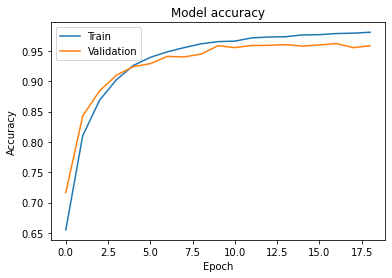

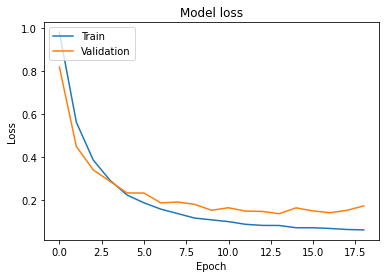

In [16]:
# Plot the accuracy for each epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()